# History of Neural Networks
- **Artificial neuron**, [McCulloch, W.S. and Pitts, W., 1943](http://aiplaybook.a16z.com/reference-material/mcculloch-pitts-1943-neural-networks.pdf): Input layer has one or more binary inputs. Output layer has one binary output. Can learn XOR. Different artificial neuron can be combined to compute complex logical expressions.
- **Perceptron**, [Rosenblatt 1957](https://blogs.umass.edu/brain-wars/files/2016/03/rosenblatt-1957.pdf): Input layer has one or more real inputs. Input layer is connected by weights to the output layer (so no hidden layers). Output layer has $P \in \mathbb{N}$ output units $h(\mathbf{x}) = \mathbb{1}_{\mathbf{x}^T \mathbf{w} \geq 0}$ for $p=1,...,P$ where $\mathbb{1}$ indicates a step function. Note that $h_i$ is a hard threshold function (i.e. not a logistic function). A unit bias is added to the input layer. Weights are trained online according to
$$w_{i, j} \leftarrow w_{i, j} - \alpha(\hat{y}_j - y_j) x_i$$
where $w_{i, j}$ refers to the weights connecting $x_i$ to $h_j$ (aka Stochastic Gradient Descent). In [Minsky, M., & Papert, S. (1969)](http://psycnet.apa.org/record/1969-35017-000) the authors showed that Perceptron cannot learn XOR because the decision boundary is linear (just like logistic regression). However, if the decision boundary is linear, the update rule converges to a solution.
- **Multi-layer perceptron and backpropagation**: Hidden layers can be added to a Perceptron to solve XOR. However, training was hard until when [DE Rumelhart, GE Hinton, RJ Williams, 1985](https://goo.gl/Wl7Xyc) presented backpropagation (today known as gradient descent using reverse-mode autodiff), a suitable learning algorithm to find $\mathbf{W}$. Backpropagation: for each training instance
    1. Compute $\hat{y}_j = \sigma(.)$ where $\sigma(.)$ is a logistic function (forward pass)
    2. Go through each layer in reverse to measure the error contribution from each connection (reverse pass)
    3. Update the weights with gradient descent.
    
Output units can now be transformed with softmax of logistic function, which are suitable differentiable functions for the gradient descent.

# Training a MLP using plain tensorflow on MNIST
The goal is to train a MLP using mini-batch gradient descent on MNIST using the low-level tensorflow API.

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
import cufflinks
import os
import matplotlib.pyplot as plt
from utils import show_graph
from datetime import datetime
%matplotlib inline
cufflinks.go_offline()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [2]:
# Load MNIST and split in training, validation and test set.
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Sizes of the dataset.
train_size, pixels_rows, pixels_cols = X_train.shape
test_size, _, _ = X_test.shape
nr_features = pixels_rows * pixels_cols
nr_labels = len(np.unique(y_train))

# split X_train in smaller X_train and X_valid.
split_threshold = int(train_size * 0.7)  
X_test = X_test.reshape(test_size, pixels_rows * pixels_cols) / 255.
X_train = X_train.reshape(train_size, pixels_rows * pixels_cols) / 255.
X_train, X_valid = X_train[:split_threshold], X_train[split_threshold:]
y_train, y_valid = y_train[:split_threshold], y_train[split_threshold:]

## Construction phase
There are a few necessary building block to define our computation graph representing a MLP, one for each of the following sub-sections.

### Data
A MLP is a function $h : \mathbf{x} \in \mathbb{R}^n \mapsto \hat{y} \in \mathbb{R}$. For MNIST (classification), input $\mathbf{x}$ corresponds to an 27x27 image of a hand-written digit and $\hat{y}$ refers to the predicted label.

Ideally, we want our code to be able to handle vectorised operations (i.e. to predict in batches) so $h : X \in \mathbb{R}^{b \times n} \mapsto \hat{y} \in \mathbb{R} ^ b$ where $b \in \mathbb{N}$ indicates the batch size. This generalisation will help training mini-batch gradient descent more efficiently.

Setting $b$ to $\texttt{None}$ allows to provide a flexible number of observations without enforcing a pre-defined number. If we specified a value, say $b = 10$, an exception will be raised whenever the amount observations passed to the MLP differs from 10.

In [3]:
tf.reset_default_graph()
X = tf.placeholder(dtype=tf.float32, shape=(None, nr_features), name='X')
y = tf.placeholder(dtype=tf.int32, shape=(None), name='y')

### Neural Network architecture
We define a MLP with the following architecture:
- Input layer: accepts tensors with any number of overvations (row) and a fixed number of features ($\texttt{mnist_n_inputs}$).
- Hidden layer: 300 units, ReLU
- Hidden layer: 100 units, ReLU
- Output layer: 10 units, linear. Logits will be passed to softmax in order to map logits to probabilities, which will be needed to define the loss function (cross-entropy).


In [4]:
with tf.name_scope('nn-architecture'):
    hidden_layer_1 = tf.layers.dense(
        inputs=X,
        units=300,
        activation=tf.nn.relu,
        name='hidden_layer_1',
    )
    hidden_layer_2 = tf.layers.dense(
        inputs=hidden_layer_1,
        units=100,
        activation=tf.nn.relu,
        name='hidden_layer_2',
    )
    logits = tf.layers.dense(
        inputs=hidden_layer_2,
        units=nr_labels,
        name='output_layer',
    )

### Loss function
We use the cross-entropy loss to train our MLP defined as

$$H(\hat{p}) =  - \frac{1}{m} \sum_{i=1}^m \sum_{c=1}^C I_{[y_i = c]} \log_2 \hat{p}(y_i = c)$$
where
$$ \hat{p}(y_i = c) = \text{softmax}(\mathbf{z}_{i, c}) = \frac{e^{\mathbf{z}_{i, c}}}{\sum_{c=1}^C e^{\mathbf{z}_{i, c}}}.$$


Having two different functions to compute the cross entropy loss directly from logits is a convenience, as they produce the same result:
- $\texttt{tf.nn.softmax_cross_entropy_with_logits}$: labels must have the shape [batch_size, num_classes] and dtype float.
- $\texttt{tf.nn.sparse_softmax_cross_entropy_with_logits}$: labels must have the shape [batch_size] and the dtype int. Each label is an int in range [0, num_classes-1].

Note that in our case batch_size is flexible because it was set to $\texttt{None}.$

In [5]:
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y,
        logits=logits,
        name='cross_entropy',
    )
    cross_entropy_loss = tf.reduce_mean(cross_entropy)

### Optimiser
Here we define the gradient descent to minimise the cross-entropy loss. `minimize` adds operations to minimize `loss` by updating `var_list`. This method simply combines calls to `compute_gradients` and `apply_gradients`. The latter approach allows to applying logic to the gradient before being used to update the weights (e.g. clipping).

In [6]:
with tf.name_scope('gradient_descent'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01, name='gradient_descent')

    # You could equivalently use training_op = optimizer.minimize(cross_entropy).
    gradients = optimizer.compute_gradients(cross_entropy)
    training_op = optimizer.apply_gradients(grads_and_vars=gradients, name='apply_gradient')

### Validation
Convert logits to $\hat{y}$ for each observation in the batch. If the labels were originally stored as integer labels, pass them directly to `tf.nn.in_top_k()` without converting them to one-hot.

Refernce: [Stackoverflow - TensorFlow in_top_k evaluation input argumants](https://stackoverflow.com/questions/36080445/tensorflow-in-top-k-evaluation-input-argumants)

In [7]:
with tf.name_scope('validation'):
    is_correct_label_int = tf.nn.in_top_k(
        predictions=logits,
        targets=y,
        k=1,
        name='is_correct_label_vec',
    )
    is_correct_label_float = tf.cast(is_correct_label_int, tf.float32)
    accuracy = tf.reduce_mean(is_correct_label_float, name='accuracy')

### Computation graph
Visualise computation graph.

In [8]:
show_graph(tf.get_default_graph())

## Execution phase
Note that the only information of the dataset used so far is the number of labels and features. This is to remark that we don't actually need any data to construct the computation graph.

We are now ready to run the computational graph providing mini-batches of 50 observations each. The main logic added here is related with saving the model and evaluation metrics periodically. We do not discuss design choices because we are mainly focusing on learning the tesorflow API as opposed to improve the validation accuracy.

In [9]:
# Parameters
n_epochs = 10
batch_size = 50
batch_iters = len(X_train) // batch_size

In [10]:
saver = tf.train.Saver()

# Construction phase. Save summary statistics for Tensorboard.
dir_log = 'tf_logs/run_{}/'.format(datetime.utcnow().strftime('%Y%m%d_%H%M%S'))
summary_accuracy_train = tf.summary.scalar('Accuracy_train', accuracy)
summary_accuracy_valid = tf.summary.scalar('Accuracy_valid', accuracy)
file_writer = tf.summary.FileWriter(dir_log, graph=tf.get_default_graph())

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        for batch_iter in range(batch_iters):
            batch_idx_start = batch_iter * batch_size
            batch_idx_end = (1 + batch_iter) * batch_size
            X_batch = X_train[batch_idx_start:batch_idx_end]
            y_batch = y_train[batch_idx_start:batch_idx_end]
            session.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_train = session.run(accuracy, feed_dict={X: X_train, y: y_train})
        accuracy_valid = session.run(accuracy, feed_dict={X: X_valid, y: y_valid})
        print('Epoch: {}; Training accuracy: {}; Validation accuracy: {}.'.format(epoch, accuracy_train, accuracy_valid))
        
        # Save model
        path_model = os.path.join('tf_checkpoints', 'session.ckpt')
        saver.save(session, path_model)
        
        # Save summary stats.
        file_writer.add_summary(
            summary=session.run(summary_accuracy_train, feed_dict={X: X_train, y: y_train}),
            global_step=epoch,
        )
        file_writer.add_summary(
            summary=session.run(summary_accuracy_valid, feed_dict={X: X_valid, y: y_valid}),
            global_step=epoch,
        )
        # Flush. See: https://github.com/tensorflow/tensorflow/issues/2353#issuecomment-287516024
        file_writer.flush()



Epoch: 0; Training accuracy: 0.9659761786460876; Validation accuracy: 0.9564999938011169.
Epoch: 1; Training accuracy: 0.9764761924743652; Validation accuracy: 0.964722216129303.
Epoch: 2; Training accuracy: 0.9784285426139832; Validation accuracy: 0.9628333449363708.
Epoch: 3; Training accuracy: 0.986547589302063; Validation accuracy: 0.9695000052452087.
Epoch: 4; Training accuracy: 0.9820952415466309; Validation accuracy: 0.9643333554267883.
Epoch: 5; Training accuracy: 0.9880238175392151; Validation accuracy: 0.9712222218513489.
Epoch: 6; Training accuracy: 0.9895952343940735; Validation accuracy: 0.9704444408416748.
Epoch: 7; Training accuracy: 0.9887857437133789; Validation accuracy: 0.9684444665908813.
Epoch: 8; Training accuracy: 0.9948333501815796; Validation accuracy: 0.9743888974189758.
Epoch: 9; Training accuracy: 0.9937381148338318; Validation accuracy: 0.9721111059188843.


Load pre-trained model and compute test error.

In [11]:
with tf.Session() as session:
    # Load pre-trained model and print test accuracy.
    loader = tf.train.import_meta_graph(path_model + '.meta')
    loader.restore(session, path_model)
    accuracy_test = session.run(accuracy, feed_dict={X: X_test, y: y_test})
    print('Test accuracy: {}'.format(accuracy_test))

INFO:tensorflow:Restoring parameters from tf_checkpoints/session.ckpt
Test accuracy: 0.975600004196167


Plot some misslabelled test digit.

In [12]:
p_hat = tf.nn.softmax(logits)
y_hat = tf.argmax(p_hat, axis=1)

with tf.Session() as session:
    # Load pre-trained model and print test accuracy.
    loader = tf.train.import_meta_graph(path_model + '.meta')
    loader.restore(session, path_model)
    p_hat_eval = session.run(p_hat, feed_dict={X: X_test, y: y_test})
    y_hat_eval = session.run(y_hat, feed_dict={X: X_test, y: y_test})

INFO:tensorflow:Restoring parameters from tf_checkpoints/session.ckpt


In [13]:
p_hat_df = pd.DataFrame(p_hat_eval, columns=['p_hat(y={})'.format(i) for i in range(nr_labels)])
p_hat_highest = [p_hat_df.iloc[i, y_hat_eval[i]] for i in range(len(X_test))]
p_hat_true = [p_hat_df.iloc[i, y_test[i]] for i in range(len(X_test))]
is_correct = y_hat_eval == y_test
p_hat_gap = pd.Series(p_hat_highest) - pd.Series(p_hat_true)
results = pd.concat([
    pd.Series(y_hat_eval).to_frame('y_hat'),
    pd.Series(y_test).to_frame('y'),
    pd.Series(is_correct).to_frame('is_correct'),
    pd.Series(p_hat_gap).to_frame('p_hat_gap'),
    pd.Series(p_hat_highest).to_frame('p_hat_highest'),
    pd.Series(p_hat_true).to_frame('p_hat_true'),
    p_hat_df,
], axis='columns')
results.sort_values('p_hat_gap', ascending=False)

,y_hat,y,is_correct,p_hat_gap,p_hat_highest,p_hat_true,p_hat(y=0),p_hat(y=1),p_hat(y=2),p_hat(y=3),p_hat(y=4),p_hat(y=5),p_hat(y=6),p_hat(y=7),p_hat(y=8),p_hat(y=9)
2654,1,6,False,1.000000,1.000000,9.799955e-10,6.039241e-16,1.000000e+00,1.375087e-09,6.340134e-17,1.108508e-10,2.419757e-15,9.799955e-10,2.874633e-08,6.264926e-11,1.903757e-15
1181,1,6,False,1.000000,1.000000,6.508886e-08,1.719988e-09,9.999996e-01,2.663332e-11,4.633816e-10,2.004915e-08,1.925432e-09,6.508886e-08,2.965463e-07,3.212247e-08,7.028678e-11
9664,7,2,False,0.999992,0.999992,1.057209e-09,1.517011e-12,7.939868e-07,1.057209e-09,2.608684e-06,1.029905e-08,2.779755e-13,5.960672e-14,9.999923e-01,5.207698e-09,4.328211e-06
9729,6,5,False,0.999978,0.999979,6.419147e-07,2.068320e-05,2.590340e-08,7.568501e-09,1.236517e-08,1.798676e-08,6.419147e-07,9.999785e-01,5.038726e-10,2.902442e-09,1.491900e-11
5887,0,7,False,0.999972,0.999986,1.375149e-05,9.999856e-01,1.511929e-11,1.060454e-09,1.676376e-08,4.353042e-09,3.931498e-09,5.025538e-07,1.375149e-05,9.628124e-13,1.323623e-07
1226,2,7,False,0.999918,0.999954,3.685551e-05,8.829818e-09,6.424936e-06,9.999545e-01,1.473153e-07,4.881197e-11,8.623062e-11,1.920501e-08,3.685551e-05,2.152878e-06,3.423246e-11
2035,3,5,False,0.999883,0.999938,5.499030e-05,8.297365e-09,3.761675e-07,2.654635e-08,9.999377e-01,3.001270e-06,5.499030e-05,4.455344e-09,1.261698e-08,2.625407e-06,1.364755e-06
720,8,5,False,0.999873,0.999873,5.446462e-08,1.381946e-09,4.159984e-08,7.754627e-11,3.454816e-13,1.862113e-09,5.446462e-08,1.264931e-04,1.926084e-10,9.998734e-01,1.261698e-10
1681,7,3,False,0.999873,0.999936,6.325457e-05,9.808149e-12,6.476016e-09,2.072887e-07,6.325457e-05,2.643282e-13,1.800418e-13,6.549169e-12,9.999365e-01,1.556421e-09,5.117501e-09
4497,7,8,False,0.999793,0.999808,1.467678e-05,6.166593e-09,1.722771e-04,1.528059e-07,3.728054e-06,4.401842e-08,5.618529e-09,1.450175e-09,9.998075e-01,1.467678e-05,1.614938e-06


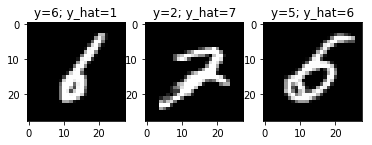

In [14]:
fig=plt.figure()
columns = 3
rows = 1
iters = columns * rows + 1
results_sorted = results.sort_values('p_hat_gap', ascending=False)
for i in range(1, iters):
    idx_digit = results_sorted.index[i]
    pixels = X_test[idx_digit].reshape(pixels_rows, pixels_cols)
    fig.add_subplot(rows, columns, i)
    plt.title('y={}; y_hat={}'.format(results.loc[idx_digit, 'y'], results.loc[idx_digit, 'y_hat']))
    plt.imshow(pixels, cmap='gray')
    
plt.show()